In [16]:
import sys
import pandas as pd
import os
import numpy as np
pd.options.display.max_columns = 50

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import openmatrix as omx

import statsmodels.api as sm 
from statsmodels.formula.api import ols 
import statsmodels.formula.api as smf

ASIM_OUTPUT = r"E:\Met_Council\metc-asim-model\Base_2018\activitysim\output"
ASIM_CONFIGS_PATH = r'E:\Met_Council\metc-asim-model\source\activitysim\configs'
SURVEY_SUMMARY_PATH = r'E:\Met_Council\metc-asim-model\Input\Visualizer\base'
SYNPOP_INPUT = r'E:\Met_Council\metc-asim-model\Input\socioeconomic'
SURVEY_PATH = r'E:\Met_Council\survey_data\Phase1\SPA_Inputs'
CENSUS_SUMMARY_PATH = r'E:\Met_Council\metc-asim-model\Input\Visualizer\census'
SKIM_PATH = r'E:\Met_Council\metc-asim-model\Base_2018\OMX\allskims.omx'
SKIM_TABLE = 'DIST'

PERTYPEMAP = {1: 'FT', 2: 'PT', 3: 'U', 4: 'NW', 5: 'R', 6: 'SD', 7: 'SPD', 8: 'PS'}
CONFIGS_CODES = {1: 'FULL', 2: 'PART', 3: 'UNIVERSITY', 4: 'NONWORK', 5: 'RETIRED', 6: 'DRIVING', 7: 'SCHOOL', 8: 'PRESCHOOL'}

# Read model data
tours = pd.read_csv(os.path.join(ASIM_OUTPUT, "final_tours.csv"))
per = pd.read_csv(os.path.join(ASIM_OUTPUT, "final_persons.csv"))

valid_summary = pd.read_csv(os.path.join(SURVEY_SUMMARY_PATH, "inmSummary_vis.csv"))
valid_summary.loc[valid_summary['nmtours'] == '3pl', 'nmtours'] = 3
valid_stats = (valid_summary.groupby(['PERTYPE', 'nmtours']).agg(survey = ('freq', 'sum')) / valid_summary.groupby(['PERTYPE']).agg(survey = ('freq', 'sum'))).reset_index()

toursINM_total = per[['person_id', 'ptype']].merge(tours[(tours['tour_category'] != 'mandatory') & (tours['number_of_participants'] == 1)].groupby('person_id').agg(nmtours = ('person_id', 'count')).clip(0, 3), left_on = 'person_id', right_index = True, how = 'left').fillna(0).groupby(['nmtours']).agg(model = ('person_id', 'count')).reset_index()
toursINM_total['percent'] = toursINM_total['model'] / toursINM_total['model'].sum()




C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_1788\350237342.py:30: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  tours = pd.read_csv(os.path.join(ASIM_OUTPUT, "final_tours.csv"))


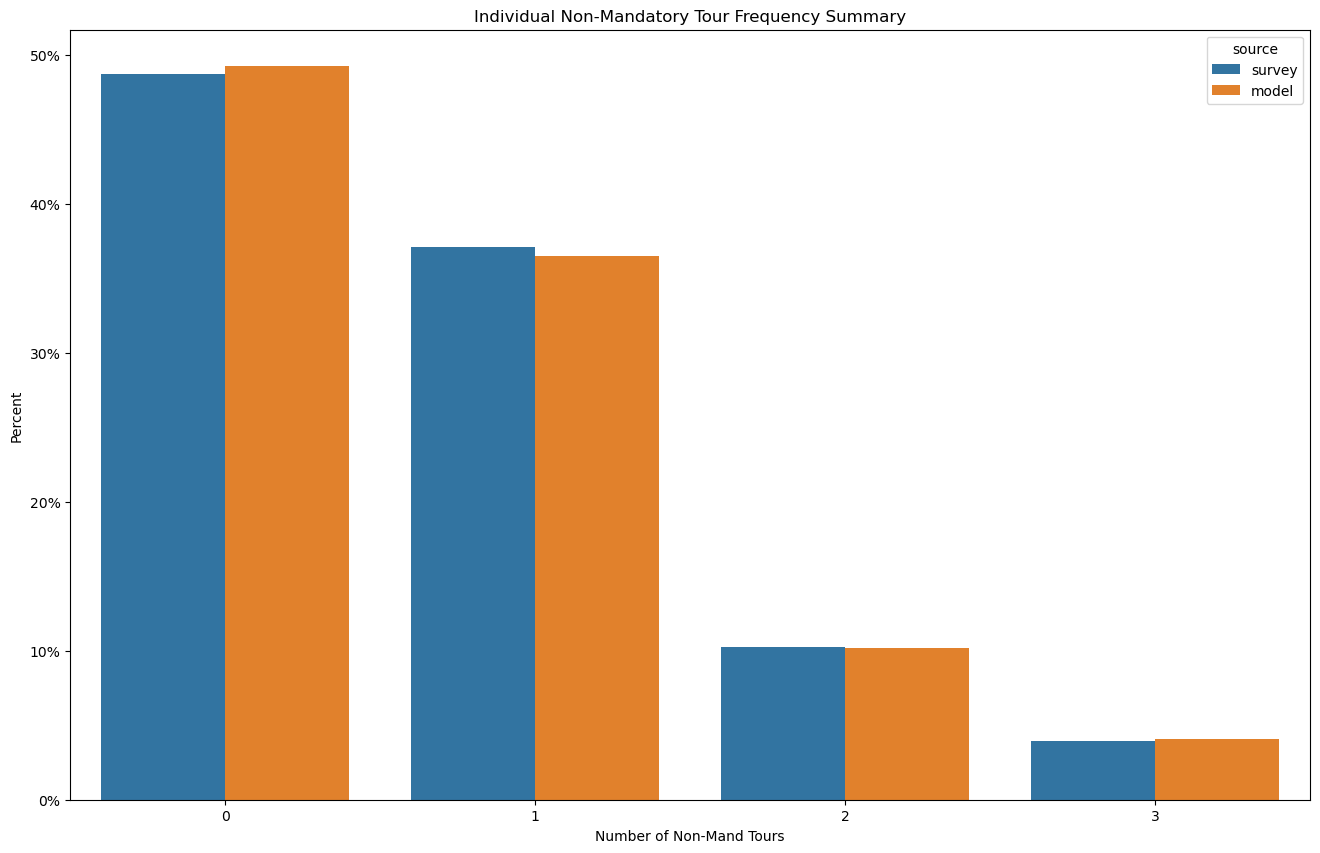

In [17]:
plot_data = pd.concat([
    valid_stats[valid_stats['PERTYPE'] == 'Total'][['nmtours', 'survey']].rename(columns = {'survey': 'percent'}).assign(source = 'survey', nmtours = lambda x: x['nmtours'].astype(int)),
    toursINM_total.assign(source = 'model', nmtours = lambda x: x['nmtours'].astype(int)),
])

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot()
sns.barplot(data = plot_data, x = 'nmtours', y = 'percent', hue = 'source')
plt.title(f"Individual Non-Mandatory Tour Frequency Summary")
# plt.xticks(fontsize=16, rotation = 90)
# plt.yticks(fontsize=16)
plt.ylabel('Percent')
plt.xlabel('Number of Non-Mand Tours')
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0%}'))
plt.show()

In [18]:
plot_data

,nmtours,percent,source,model
32,3,0.039415,survey,NaN
33,0,0.487213,survey,NaN
34,1,0.370743,survey,NaN
35,2,0.102630,survey,NaN
0,0,0.492235,model,369250.0
1,1,0.364948,model,273766.0
2,2,0.102162,model,76637.0
3,3,0.040655,model,30497.0


In [19]:
toursINM = (per[['person_id', 'ptype']].merge(tours[(tours['tour_category'] != 'mandatory') & (tours['number_of_participants'] == 1)].groupby('person_id').agg(nmtours = ('person_id', 'count')).clip(0, 3), left_on = 'person_id', right_index = True, how = 'left').fillna(0).groupby(['ptype', 'nmtours']).agg(model = ('person_id', 'count')) / per[['person_id', 'ptype']].merge(tours[(tours['tour_category'] != 'mandatory') & (tours['number_of_participants'] == 1)].groupby('person_id').agg(nmtours = ('person_id', 'count')).clip(0, 3), left_on = 'person_id', right_index = True, how = 'left').fillna(0).groupby(['ptype']).agg(model = ('person_id', 'count'))).reset_index()

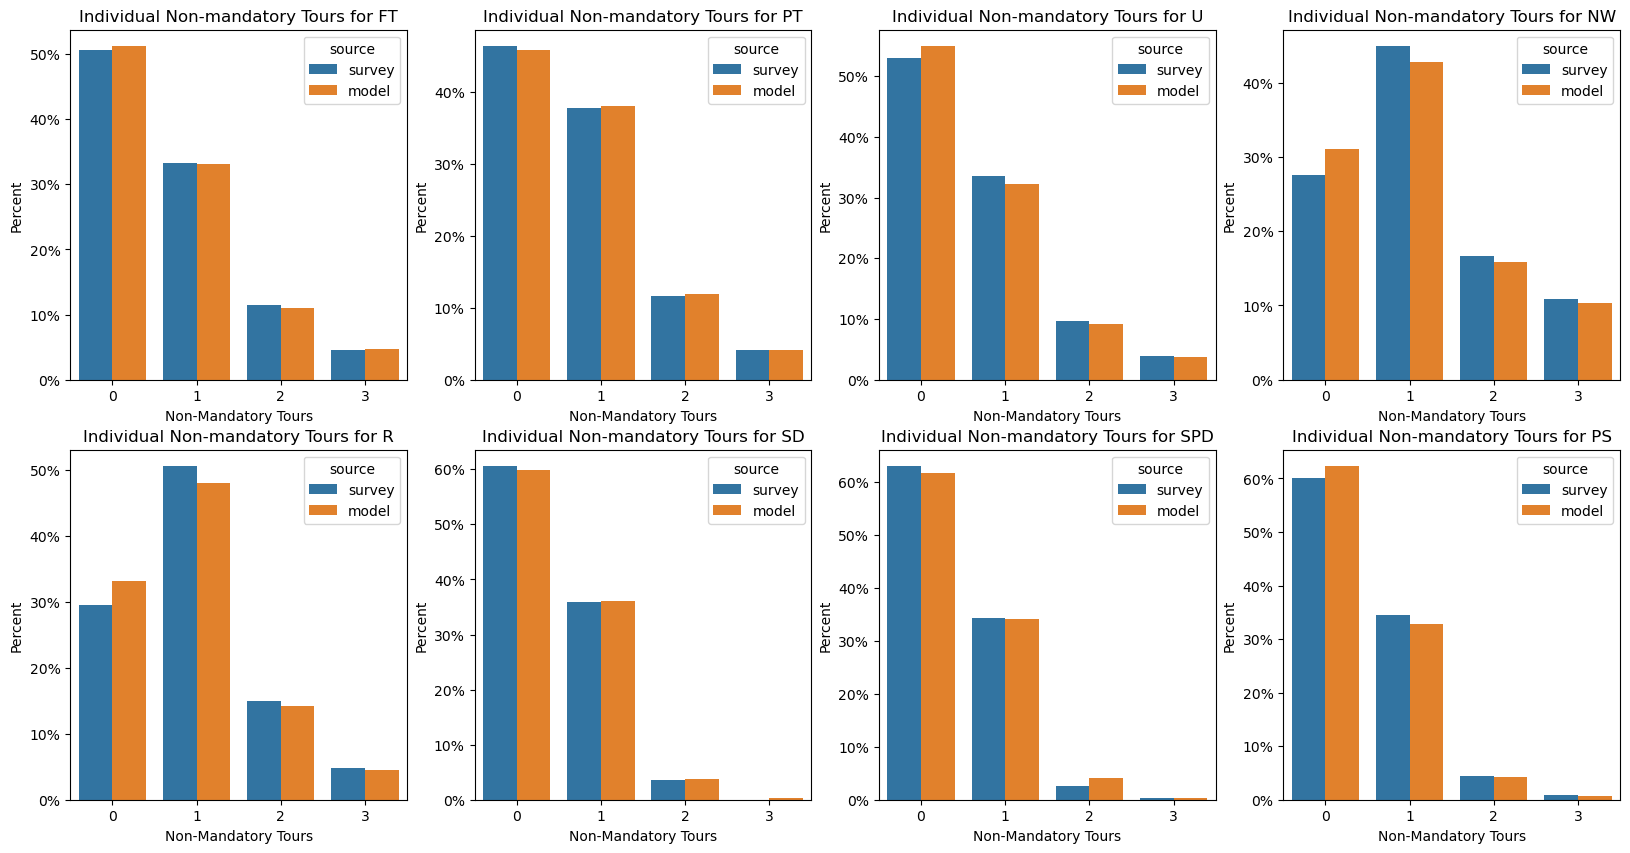

In [20]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
plot_idx = 240
count = 1

for ptype in PERTYPEMAP.keys():
    plot_data = pd.concat([valid_stats[valid_stats['PERTYPE'] == str(ptype)].rename(columns = {'PERTYPE': 'ptype', 'survey': 'percent'}).assign(source = 'survey'),
        toursINM[toursINM['ptype'] == ptype].rename(columns = {'model': 'percent'}).assign(source = 'model')])
    plot_data['nmtours'] = plot_data['nmtours'].astype(int)
    ax = plt.subplot(plot_idx + count)
    sns.barplot(data = plot_data, x = 'nmtours', y = 'percent', hue = 'source')
    plt.title(f"Individual Non-mandatory Tours for {PERTYPEMAP[ptype]}")
    # plt.xticks(fontsize=16, rotation = 90)
    # plt.yticks(fontsize=16)
    plt.ylabel('Percent')
    plt.xlabel('Non-Mandatory Tours')
    ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0%}'))
    count += 1

# Coefficient Adjustments

In [15]:
# ⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠
#NOTE: THIS WILL UPDATE ALL THE COEFFICIENTS FILES!
# ⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠


# coef_total_number_of_tours_is_1..5

for ptype in [1]:
    configs = pd.read_csv(os.path.join(ASIM_CONFIGS_PATH, f"non_mandatory_tour_frequency_coefficients_PTYPE_{CONFIGS_CODES[ptype]}.csv")).set_index("coefficient_name")

    adjust_table = valid_stats[valid_stats['PERTYPE'] == str(ptype)].rename(columns = {'PERTYPE': 'ptype'})
    adjust_table['coefficient_name'] = [f"asc_{str(x)}" for x in adjust_table['nmtours']]
    adjust_table['nmtours'] = adjust_table['nmtours'].astype(int)
    adjust_table = adjust_table.merge(toursINM[toursINM['ptype'] == ptype], how = 'left', on = 'nmtours').set_index('coefficient_name')
    adjust_table['old_value'] = configs['value'].reindex(adjust_table.index)
    adjust_table['constrain'] = configs['constrain'].reindex(adjust_table.index)
    adjust_table['adjust'] = np.log(adjust_table['survey'] / adjust_table['model']) # * 0.75
    # adjust_table['value'] = adjust_table['old_value'] + adjust_table['adjust']
    # For now, to avoid conflicting adjustments
    adjust_table.loc[adjust_table['nmtours'] == 0, 'value'] = 0.0

    update_coefs = pd.DataFrame({'coefficient_name': [f"coef_total_number_of_tours_is_{i}" for i in np.arange(1, 6)], 'nmtours': [np.minimum(3, i) for i in np.arange(1,6)]}) 
    update_coefs = update_coefs.merge(adjust_table[['nmtours', 'adjust']], how = 'left', on = 'nmtours').set_index('coefficient_name').join(configs).rename(columns = {'value': 'old_value'})
    update_coefs['value'] = update_coefs['old_value'] + update_coefs['adjust']
    update_coefs.loc[update_coefs['constrain'] == 'T', 'value'] = update_coefs['old_value']
    configs.update(update_coefs['value'])
    configs.to_csv(os.path.join(ASIM_CONFIGS_PATH, f"non_mandatory_tour_frequency_coefficients_PTYPE_{CONFIGS_CODES[ptype]}.csv"))

